# App Test Drive
* In this notebook we'll sequentially go thru each steps of the app, before we convert into a fully fledged web app. 

## Import Libraries

In [5]:
import os
import json

import PIL
from google import genai
from PIL import Image
from io import BytesIO
from IPython.display import display

from pathlib import Path
from datetime import datetime

## Setup Constants

In [35]:
image_dir = Path("..","images")
ai_image_dir = Path(image_dir,"ai_images")
data_dir = Path("..", "data")

IMAGE_MODEL_ID = "gemini-2.5-flash-image-preview"
TEXT_MODEL_ID = "gemini-2.5-flash-lite"

## Client Setup

In [ ]:
# read api key
API_KEY = os.environ.get("GEMINI_API_KEY")


# configure the client with your API key
client = genai.Client(api_key=API_KEY)

## Utils

In [4]:
def save_and_display_response(response, file_name = f"image_{datetime.now().timestamp()}.png"):
    image_parts = [
        part.inline_data.data
        for part in response.candidates[0].content.parts
        if part.inline_data
    ]
    
    if image_parts:
        image = Image.open(BytesIO(image_parts[0]))
        image.save(f"{ai_image_dir}/{file_name}")
        display(image)

## Theme Config

In [41]:
THEME_CONFIG = {
    "Haunted Space Station": {
        "character_prompt_template": "A {gender} hero wearing a worn, high-tech scavenger jumpsuit, equipped with a side-mounted plasma cutter and a wrist-mounted data-pad. The expression is a mix of determination and apprehension.",
        "story_theme_prompt": "A tense, sci-fi horror adventure about a rescue mission on a derelict space station teeming with strange alien phenomena."
    },
    "Lost Temple of the Jungle": {
        "character_prompt_template": "A {gender} explorer wearing practical, moisture-wicking gear, with a coiled whip on their belt and a leather-bound journal in a satchel. The expression is curious and brave.",
        "story_theme_prompt": "A classic pulp adventure to find a legendary artifact in a jungle temple filled with ancient traps and mysterious guardians."
    },
    "Cyberpunk Underworld": {
        "character_prompt_template": "A {gender} street samurai with subtle cybernetic enhancements around one eye, wearing a stylish neo-noir trench coat over light tactical armor. The expression is sharp and street-wise.",
        "story_theme_prompt": "A gritty, neon-noir investigation into a corporate conspiracy in the rain-slicked back-alleys of a futuristic metropolis."
    },
    "Curse of the Banana King": {
        "character_prompt_template": "A daring {gender} treasure hunter wearing a weathered fedora and a bright yellow bandana. They are equipped with a mystical, banana-shaped compass and a sharp machete for cutting through dense jungle foliage. The expression is a mix of excitement and unease.",
        "story_theme_prompt": "A thrilling, slightly absurd treasure hunt to find the mythical Golden Banana in a temple cursed by the ancient Banana King, where the banana trees are rumored to watch your every move."
    }
}

DEFAULT_THEME = "Curse of the Banana King"


## Step 1 - Setup Screen

* In this screen we'll give users few choices of story theme and based on their selection we'll create the story and character for them. 
* We'll use GenAI to generate this story and will try and use it to create prompts for image and text. 

### Prompt

In [42]:
setup_screen_prompt_template = """
You are a creative and expert Dungeon Master AI. Your task is to design a short, branching adventure story based on a user-provided theme and a desired number of steps for a successful playthrough.

The theme is: "{theme}"
The successful path length must be exactly: {step_count} steps.

Your output MUST be a single, valid JSON object. Do not include any text, notes, or markdown formatting (like ```json) before or after the JSON block.

The JSON object must conform to the following rules and schema:

1.  **prologue**: A compelling background story (2-3 sentences) explaining the hero's motivation and setting the scene.
2.  **story_tree**: This must be a LIST of story node objects. The first object in the list is the starting point of the adventure and MUST have its id field set to "start".
3.  **scene_description**: A visually rich and descriptive text prompt (2-3 sentences) for an AI image generator.
4.  **narration**: Text for an AI voice to narrate the scene (2-3 sentences).
5.  **choices**: An array of 1 or 2 choice objects. Ending nodes must have an empty `[]` choices array.
6.  **is_ending**: A boolean (`true` or `false`). This MUST be `true` for any node that represents an end to the game.
7.  **outcome**: A string, either `"success"` or `"failure"`. This key MUST be present if and only if `is_ending` is `true`.
8.  **Failure Paths**: You MUST include at least one path that leads to a `failure` outcome. Failure paths can be shorter than the successful path.

Here is the exact schema for each node within the `story_tree`:
{{
  "id": "string",
  "scene_description": "string",
  "narration": "string",
  "choices": [
    {{
      "text": "string",
      "next_id": "string"
    }}
  ],
  "is_ending": "boolean",
  "outcome": "string (optional: 'success' or 'failure')"
}}

Now, generate the complete JSON for my adventure.
"""

### Reponse Model

In [43]:
from pydantic import BaseModel
from typing import List, Optional, Literal

# No changes are needed for the Choice class.
class Choice(BaseModel):
    """
    Represents a single choice a player can make.
    """
    text: str
    next_id: str


class StoryNode(BaseModel):
    """
    Represents a single step in the story.
    We've added the 'id' field here to uniquely identify each node.
    """
    id: str  # <-- The new field you suggested!
    scene_description: str
    narration: str
    choices: List[Choice]
    is_ending: bool
    outcome: Optional[Literal["success", "failure"]] = None


class Story(BaseModel):
    """
    Represents the entire adventure.
    The 'story_tree' is now a List of StoryNode objects instead of a Dictionary.
    This resolves the `additionalProperties` error with the Gemini API.
    """
    prologue: str
    story_tree: List[StoryNode]

### Call

In [44]:
def generate_story(theme=THEME_CONFIG[DEFAULT_THEME]["story_theme_prompt"], step_count=3):
    # format the final prompt
    final_prompt = setup_screen_prompt_template.format(
        theme=theme, step_count=step_count)

    response = client.models.generate_content(
        model=TEXT_MODEL_ID,
        contents=final_prompt,
        config={
            "response_mime_type": "application/json",
            "response_schema": Story
        }
    )
    story_json_text = response.text
    # parse story data
    story_data = json.loads(story_json_text)
    # return story data
    return story_data

In [46]:
# --- Define Your Game Parameters ---
theme = THEME_CONFIG[DEFAULT_THEME]["story_theme_prompt"]
step_count = 3

## commenting out to avoid multiple API calls
# story_data = generate_story(
#     theme=theme, step_count=step_count
# )

# story_data

In [47]:
## reading story data from saved file for future use. 
with open(Path(data_dir,"adventure.json"), "r") as file:
    story_data = json.load(file)
    
story_data

{'prologue': 'Legends whisper of the Golden Banana, an artifact of unparalleled deliciousness and immense power, hidden within the Temple of the Watchful Trees. You, a renowned (or perhaps just very hungry) adventurer, have braved treacherous jungles to seek this legendary fruit, said to grant eternal potassium.',
 'story_tree': [{'id': 'start',
   'scene_description': 'A grand, ancient temple entrance carved into a mountainside, overgrown with lush jungle vines. Giant, gnarled banana trees with unsettlingly human-like knots stand sentinel on either side. Sunlight filters through the dense canopy, casting eerie shadows.',
   'narration': 'You stand before the fabled Temple of the Watchful Trees. The air is thick with humidity and the scent of overripe fruit. The ancient banana trees seem to lean in, their leafy canopies like watching eyes.',
   'choices': [{'text': 'Enter the temple boldly.', 'next_id': 'main_hall'},
    {'text': 'Try to sneak around the watchful trees.',
     'next_id

## Step 2 - Character Generation
* In this screen we'll let the user upload a selfie and generate a character using the nano banan model

### Prompt

### Call

In [65]:
def generate_character_asset(theme: str, gender: str, selfie_image: Image.Image) -> Image.Image:
    """
    Generates a character asset image based on a theme, gender, and user selfie.

    Args:
        theme: The selected story theme (e.g., "Haunted Space Station").
        gender: The selected character gender (e.g., "male", "female").
        selfie_image: A PIL Image object of the user's selfie.
        model: The initialized Gemini generative model.

    Returns:
        A PIL Image object of the generated character asset.
    """
    ## read theme config
    theme_data = THEME_CONFIG.get(theme, THEME_CONFIG[DEFAULT_THEME])
    base_prompt = theme_data.get("character_prompt_template")
    
    ## prepare the prompt
    character_description = base_prompt.format(gender=gender)
    prompt_parts = [
        "You are an expert photorealistic editor responsible to create accurate video game characters from selfies. Your task is to edit the following selfie image.",
        selfie_image,
        "**Primary Objective:** Create a photorealistic character portrait suitable for a video game.",
        "**Rule 1 (CRITICAL):** Do NOT change the person's face or hair. The likeness must be perfectly preserved.",
        f"**Rule 2:** Replace the person's current clothing with the following: {character_description}.",
        "**Rule 3:** Replace the original background with a neutral, grey studio backdrop for a character sheet.",
        "The final image should be a high-resolution, photorealistic portrait."
    ]
    
    response = client.models.generate_content(
        model=IMAGE_MODEL_ID,
        contents=prompt_parts
    )
    
    
    for part in response.candidates[0].content.parts:
        # if part.text is not None:
        #     print(part.text)
        if part.inline_data is not None:
            image = Image.open(BytesIO(part.inline_data.data))
            image.save(Path(ai_image_dir,"character_sheet.png"))
    
    return image
    

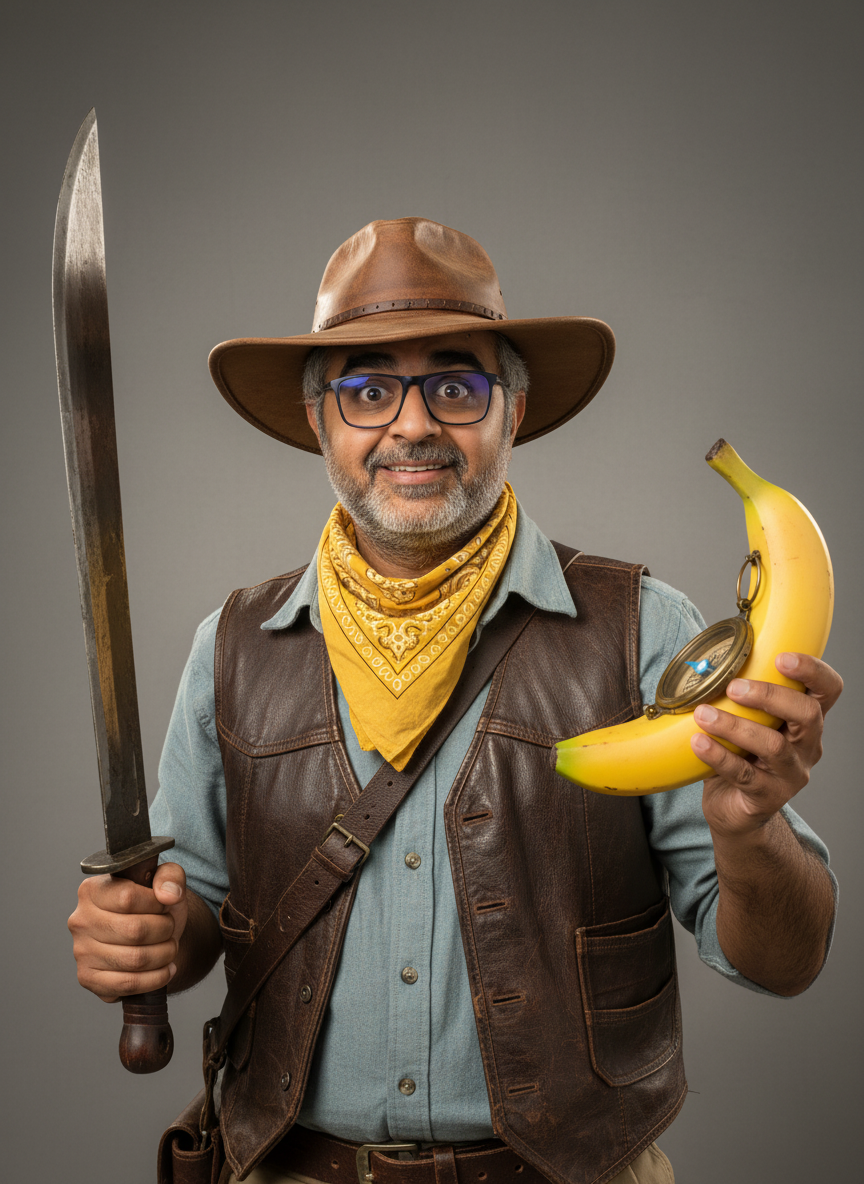

In [66]:
selfie_image = Image.open(Path(image_dir,"me.jpg"))
generate_character_asset(theme=DEFAULT_THEME,gender="Male",selfie_image=selfie_image)